### В этой работе:
1. Скачаем [датасет](https://www.manythings.org/anki/rus-eng.zip) англо-русскую пару фраз
2. Обучим seq2seq модель используя механизм внимания
3. Оценим качество модели

### Загрузим данные

In [113]:
%matplotlib inline

In [84]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# загрузим данные
!wget https://www.manythings.org/anki/rus-eng.zip

In [ ]:
# распакуем
import zipfile

with zipfile.ZipFile(r"D:\Progect\RNN\rus-eng.zip", 'r') as zip_ref:
    zip_ref.extractall("D:\Progect\RNN")

In [87]:
# смотрим что внутри, выведем последние 10 строк текста
with open(r"/content/eng-rus.txt", 'r') as file:
    lines = file.readlines()
    for line in lines[-10:]:  # Shows last 10 lines
        print(line.strip())

We need to uphold laws against discrimination — in hiring, and in housing, and in education, and in the criminal justice system. That is what our Constitution and our highest ideals require.	Нам нужно отстаивать законы против дискриминации при найме на работу, в жилищной сфере, в сфере образования и правоохранительной системе. Этого требуют наша Конституция и высшие идеалы.	CC-BY 2.0 (France) Attribution: tatoeba.org #5762728 (BHO) & #6390439 (odexed)
I've heard that you should never date anyone who is less than half your age plus seven. Tom is now 30 years old and Mary is 17. How many years will Tom need to wait until he can start dating Mary?	Я слышал, что никогда не следует встречаться с кем-то вдвое младше вас плюс семь лет. Тому 30 лет, a Мэри 17. Сколько лет Тому нужно ждать до тех пор, пока он сможет начать встречаться с Мэри?	CC-BY 2.0 (France) Attribution: tatoeba.org #10068197 (CK) & #10644473 (notenoughsun)
I do have one final ask of you as your president, the same thing I a

### Выполним предварительную обработку данных

In [88]:
SOS_token = 0   # Start of sequence
EOS_token = 1   # End of sequence

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [89]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427

# преобразуем символы Unicode в ASCII, сделаем все строчными и удалим большую часть знаков препинания
# удалим диакритические знаки
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'  # проверяем, что категория символа c не является "Mn" (Mark, Nonspacing), то есть это не диакритический знак.
    )

# проведем предобработку текста
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    # s = re.sub(r"[^а-яА-Я.!?]+", r" ", s)
    return s

In [90]:
# прочитаем текст с парами предложений
# флаг reverse, указывает нужно ли поменять язык перевода местами
# если  reverse=True - меняем порядок предложений в каждой паре
# если reverse=False - оставляем порядок предложений без изменений
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Прочитаем текст построчно
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # разделитель в тексте разный, в моем случаее это CC-BY
    lines = [i.split('\tCC-BY', 1)[0] for i in lines]

    # Соеденим каждую строку в пару предложений, проведем нормализацию текста
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Возвращаем список пар слов
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [91]:
# максимальное количество слов в предложении
MAX_LENGTH = 20

# Префиксы для предложений
ENGLISH_PREFIXES = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filter_pair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(ENGLISH_PREFIXES)

def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

In [92]:
# функция подготовки данных для машинного перевода
# lang1 и lang2 - коды языков (например, 'eng' для английского, 'rus' для русского)
# reverse=False - направление перевода
def prepareData(lang1, lang2, reverse=False):

    # выведим количество прочитанных пар предложений
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))

    # выведим количество пар предложений после фильтрации
    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

    # выводит имя языка и количество уникальных слов
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

# параметры машинного перевода: 'eng' - английский язык, 'rus' - русский язык
# True - перевод будет осуществляться с русского на английский
input_lang, output_lang, pairs = prepareData('eng', 'rus', True)

# проверим корректность работы функции
print(random.choice(pairs))

Reading lines...
Read 496059 sentence pairs
Trimmed to 5113 sentence pairs
Counting words...
Counted words:
rus 4792
eng 2446
['он тоже не придет .', "he isn't coming, either ."]


Прочитали 496 059 пар предложений   
После фильтрации осталось 5113 пар предложений   
Посчитали количество уникальных пар предложений:   
для русского языка - 4792   
для английского языка - 2446   

При этом, если мы изменим параметр MAX_LENGTH больше чем 20, тогда получим большее число уникальных предложений, если уменьшим, то, соответственно получим меньшее количество уникальных предложений

-------------------------------------
Если на этом этапе в результате предобработки мы увидели корректный текст на двух разных языках (в нашем варианте 'eng'и 'rus'), тогда можно приступать к следующему шагу, к созданию архитектуры модели и её обучению.    
Если до этого момента на выходе получили непонятный текст или ошибку, то следует вернуться к повторной обработке данных, пока не получим корректный результат.

### Архитектура Seq2Seq модели

Сеть Sequence to Sequence или сеть Encoder Decoder, представляет собой модель, состоящую из двух RNN, называемых encoder и decoder. Encoder считывает входную последовательность и выводит один вектор, а decoder считывает этот вектор, чтобы создать выходную последовательность.

Исходный код был взят по ссылке [NLP From Scratch: Translation with a Sequence to Sequence Network and Attention](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

In [93]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

Декодер — это еще одна RNN, которая берет выходные векторы кодера и выводит последовательность слов для создания перевода.

In [94]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [95]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

### Обучение
#### Подготовка обучающих данных
Для обучения нам для каждой пары понадобится входной тензор (индексы слов во входном предложении) и целевой тензор (индексы слов в целевом предложении). При создании этих векторов мы добавим токен EOS к обеим последовательностям.

In [96]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'rus', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

#### Обучение модели
Для обучения мы пропускаем входное предложение через кодер и отслеживаем каждый выход и последнее скрытое состояние. Затем декодеру дается <SOS>токен в качестве его первого входа, а последнее скрытое состояние кодера — в качестве его первого скрытого состояния.

«Teacher forcing» — это концепция использования реальных целевых выходов в качестве каждого следующего входа вместо использования догадки декодера в качестве следующего входа. Использование teacher forcing заставляет его сходиться быстрее, но когда обученная сеть эксплуатируется, она может проявлять нестабильность .

In [97]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

Это вспомогательная функция для вывода прошедшего времени и предполагаемого оставшегося времени с учетом текущего времени и процента прогресса.

In [98]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [99]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [100]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    show_plot(plot_losses)

#### Построение результатов

In [101]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

#### Обучение модели

Для обучения мы пропускаем входное предложение через кодер и отслеживаем каждый выход и последнее скрытое состояние. Затем декодеру дается <SOS>токен в качестве его первого входа, а последнее скрытое состояние кодера — в качестве его первого скрытого состояния.

«Teacher forcing» — это концепция использования реальных целевых выходов в качестве каждого следующего входа вместо использования догадки декодера в качестве следующего входа. Использование teacher forcing заставляет его сходиться быстрее, но когда обученная сеть эксплуатируется, она может проявлять нестабильность .

In [102]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [103]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

#### Обучение и оценка


In [104]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

Reading lines...
Read 496059 sentence pairs
Trimmed to 5113 sentence pairs
Counting words...
Counted words:
rus 4792
eng 2446
0m 34s (- 8m 31s) (5 6%) 1.3170
1m 6s (- 7m 48s) (10 12%) 0.7292
1m 39s (- 7m 13s) (15 18%) 0.4753
2m 13s (- 6m 39s) (20 25%) 0.3048
2m 46s (- 6m 5s) (25 31%) 0.1920
3m 18s (- 5m 31s) (30 37%) 0.1200
3m 51s (- 4m 58s) (35 43%) 0.0749
4m 24s (- 4m 24s) (40 50%) 0.0481
4m 57s (- 3m 51s) (45 56%) 0.0326
5m 30s (- 3m 18s) (50 62%) 0.0239
6m 3s (- 2m 45s) (55 68%) 0.0190
6m 36s (- 2m 12s) (60 75%) 0.0156
7m 9s (- 1m 39s) (65 81%) 0.0135
7m 42s (- 1m 6s) (70 87%) 0.0121
8m 15s (- 0m 33s) (75 93%) 0.0109
8m 48s (- 0m 0s) (80 100%) 0.0096


#### Оценка модели

In [105]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> сегодня он, по идее, должен быть дома .
= he is supposed to be at home today .
< she at home today . <EOS>

> мы с тобои .
= we are with you .
< he is with you . <EOS>

> она боится кошек .
= she is afraid of cats .
< she is afraid of death . <EOS>

> он слишком честныи, чтобы лгать .
= he is too honest to tell a lie .
< he is too honest to tell a lie . <EOS>

> он привык путешествовать .
= he is used to traveling .
< he is used to traveling . <EOS>

> он достаточно взрослыи для того, чтобы путешествовать в одиночку .
= he is old enough to travel alone .
< he is clever enough to drive a servant . <EOS>

> я удивлен, что ты мог не знать об их браке .
= i am surprised that you should not know of their marriage .
< you aren't the only one of do it . <EOS>

> в школе не курят .
= you are not supposed to smoke at school .
< you are not supposed to school now . <EOS>

> мы не привыкли ждать .
= we aren't accustomed to waiting .
< we aren't accustomed to waiting waiting . <EOS>

> вся ответ

#### Визуализация

In [111]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

In [116]:
%matplotlib inline

input = он самыи упрямыи ребенок из тех, что я когда-либо видел
output = he is the best for the entrance examination . <EOS>


<ipython-input-111-e9e4226acec0>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-111-e9e4226acec0>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


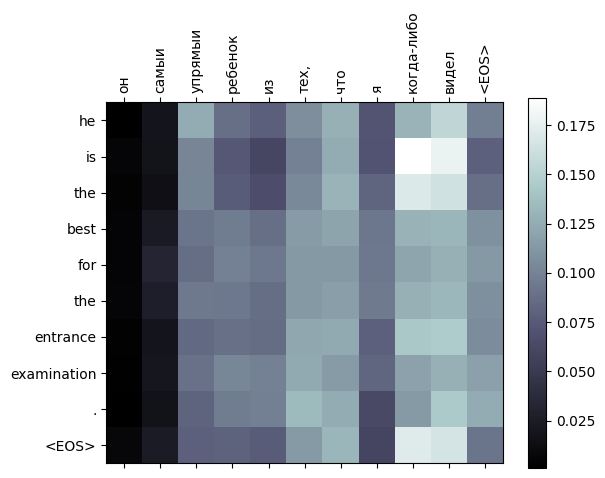

In [115]:
evaluateAndShowAttention('он самыи упрямыи ребенок из тех, что я когда-либо видел')

input = он совершенно прав
output = he is a man of his own shadow . <EOS>


<ipython-input-111-e9e4226acec0>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-111-e9e4226acec0>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


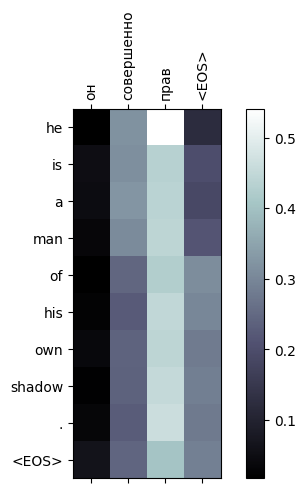

In [117]:
evaluateAndShowAttention('он совершенно прав')

### Механизм внимания на основе MLP

In [ ]:
class MLPAttention(nn.Module):
    def __init__(self, hidden_size):
        super(MLPAttention, self).__init__()
        self.W = nn.Linear(hidden_size, hidden_size)
        self.U = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1)
        
    def forward(self, query, keys):
        # query: [batch_size, hidden_size]
        # keys: [sequence_length, batch_size, hidden_size]
        weights = self.v(torch.tanh(
            self.W(query.unsqueeze(1)) + 
            self.U(keys)
        ))
        return F.softmax(weights, dim=1)

class AttnDecoderMLP(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderMLP, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = MLPAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)  # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input))
        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)
        return output, hidden, attn_weights

Reading lines...
Read 496059 sentence pairs
Trimmed to 5113 sentence pairs
Counting words...
Counted words:
rus 4792
eng 2446
0m 31s (- 7m 59s) (5 6%) 1.3514
1m 3s (- 7m 24s) (10 12%) 0.7471
1m 34s (- 6m 49s) (15 18%) 0.4889
2m 4s (- 6m 13s) (20 25%) 0.3144
2m 35s (- 5m 42s) (25 31%) 0.1972
3m 5s (- 5m 9s) (30 37%) 0.1224
3m 36s (- 4m 37s) (35 43%) 0.0751
4m 6s (- 4m 6s) (40 50%) 0.0478
4m 36s (- 3m 35s) (45 56%) 0.0321
5m 6s (- 3m 4s) (50 62%) 0.0236
5m 37s (- 2m 33s) (55 68%) 0.0184
6m 7s (- 2m 2s) (60 75%) 0.0161
6m 38s (- 1m 31s) (65 81%) 0.0138
7m 8s (- 1m 1s) (70 87%) 0.0112
7m 39s (- 0m 30s) (75 93%) 0.0112
8m 9s (- 0m 0s) (80 100%) 0.0095


<Figure size 640x480 with 0 Axes>

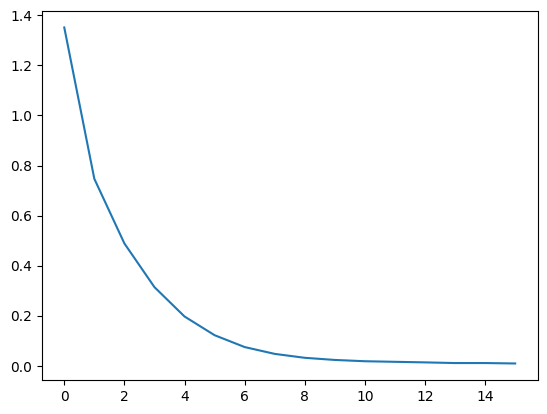

In [119]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderMLP(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

#### Оценка модели

In [120]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> ты, бесспорно, самыи большои идиот, которого я когда-либо встречал .
= you are, hands down, the biggest idiot i've ever met .
< you are, hands down, the biggest idiot i've ever met met can buy stamps . <EOS>

> я готов сделать что угодно, чтобы помочь тебе .
= i am ready to do anything to help you .
< i am planning to do it to help you . <EOS>

> он не большии глупец, чем ты .
= he is no more a fool than you are .
< he is no more a fool . <EOS>

> я ищу работу на полставки, чтобы купить себе новую видеокамеру .
= i am looking for a part-time job so i can buy a new video camera .
< i am looking for a part-time job so i can buy a new video camera in these days . <EOS>

> он немного трусоват .
= he is a bit of a coward .
< he is a little of words a lie . <EOS>

> вы не правы .
= you are wrong .
< you are wrong . <EOS>

> ты ничуть не лучше меня .
= you aren't any better than me .
< you aren't me . <EOS>

> она заплакала .
= she started crying .
< she started crying . <EOS>

> она очень 

#### Визуализация

In [121]:
%matplotlib inline

input = он самыи упрямыи ребенок из тех, что я когда-либо видел
output = he is the store exam restaurant tomorrow buy a spade call a spade japan next week . <EOS>


<ipython-input-111-e9e4226acec0>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-111-e9e4226acec0>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


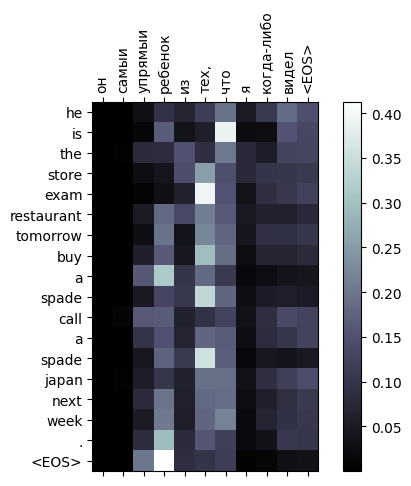

In [122]:
evaluateAndShowAttention('он самыи упрямыи ребенок из тех, что я когда-либо видел')

input = он совершенно прав
output = he is reading . <EOS>


<ipython-input-111-e9e4226acec0>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-111-e9e4226acec0>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


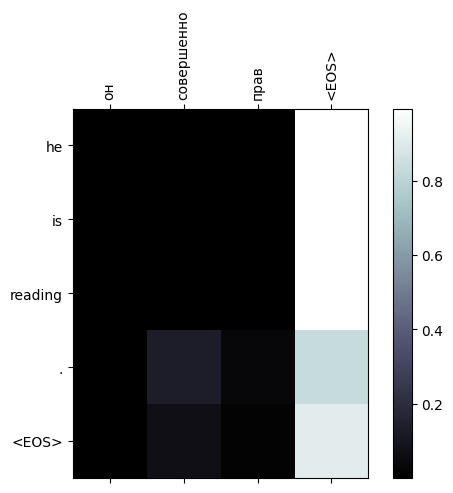

In [123]:
evaluateAndShowAttention('он совершенно прав')

### На основе скалярного произведения

In [ ]:
class DotProductAttention(nn.Module):
    def __init__(self):
        super(DotProductAttention, self).__init__()
        
    def forward(self, query, keys):
        # query: [batch_size, hidden_size]
        # keys: [sequence_length, batch_size, hidden_size]
        scores = torch.matmul(query.unsqueeze(1), keys.transpose(-2, -1))
        scores = scores / math.sqrt(keys.size(-1))  # масштабирование
        return F.softmax(scores, dim=-1)


class AttnDecoderDPA(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderDPA, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = DotProductAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1)  # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input))
        query = hidden.permute(1, 0, 2)  # (batch_size, 1, hidden_size)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)
        return output, hidden, attn_weights

Reading lines...
Read 496059 sentence pairs
Trimmed to 5113 sentence pairs
Counting words...
Counted words:
rus 4792
eng 2446
0m 23s (- 5m 52s) (5 6%) 1.3420
0m 47s (- 5m 29s) (10 12%) 0.7830
1m 10s (- 5m 5s) (15 18%) 0.5690
1m 34s (- 4m 42s) (20 25%) 0.4300
1m 57s (- 4m 18s) (25 31%) 0.3320
2m 20s (- 3m 54s) (30 37%) 0.2575
2m 44s (- 3m 31s) (35 43%) 0.1994
3m 7s (- 3m 7s) (40 50%) 0.1547
3m 31s (- 2m 44s) (45 56%) 0.1197
3m 54s (- 2m 20s) (50 62%) 0.0926
4m 18s (- 1m 57s) (55 68%) 0.0712
4m 41s (- 1m 33s) (60 75%) 0.0555
5m 5s (- 1m 10s) (65 81%) 0.0443
5m 28s (- 0m 46s) (70 87%) 0.0361
5m 52s (- 0m 23s) (75 93%) 0.0300
6m 15s (- 0m 0s) (80 100%) 0.0258


<Figure size 640x480 with 0 Axes>

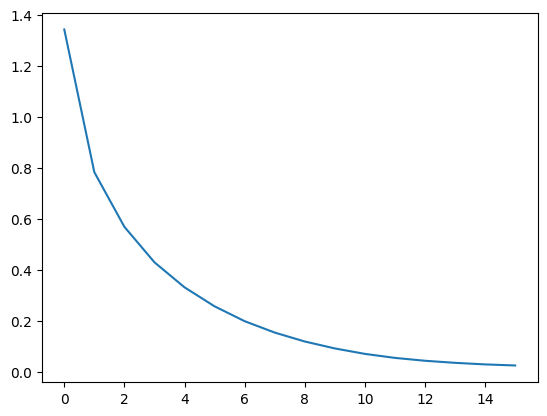

In [125]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoderDPA = AttnDecoderDPA(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoderDPA, 80, print_every=5, plot_every=5)

#### Оценка модели

In [126]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> я не занимаюсь .
= i am not studying .
< i am not yours help yours german culture lawyer debt reputation swimming said promotion it face it debt . <EOS>

> она собирается научиться водить машину .
= she is going to learn how to drive .
< SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS

> он не тот, кем был когда-то .
= he is not what he used to be .
< SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS

> в библиотеку нельзя приносить еду .
= you aren't allowed to bring food into the library .
< SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS

> они прогуливаются .
= they are taking a walk .
< SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS

> она к нему добра .
= she is kind to him .
< he is said looking your new wife's smile new car help drive die went upstairs wife SOS SOS SOS SOS

> они уже не дети, но еще и не взрослые .
= they aren't children any more, but

#### Визуализация

In [127]:
%matplotlib inline

input = он самыи упрямыи ребенок из тех, что я когда-либо видел
output = i am fact him till 5:30 . <EOS>


<ipython-input-111-e9e4226acec0>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-111-e9e4226acec0>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


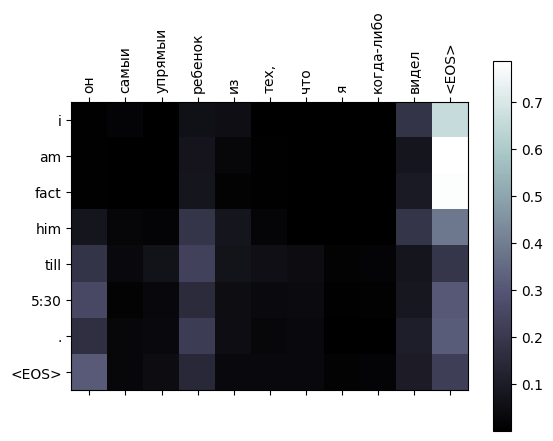

In [128]:
evaluateAndShowAttention('он самыи упрямыи ребенок из тех, что я когда-либо видел')

input = он совершенно прав
output = i am still trying so sick so so so sick . <EOS>


<ipython-input-111-e9e4226acec0>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-111-e9e4226acec0>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


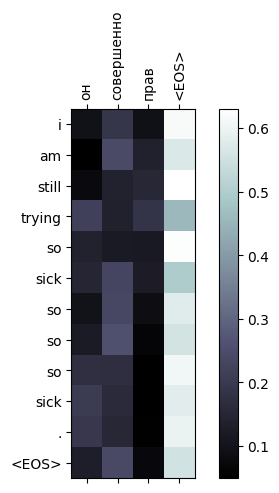

In [129]:
evaluateAndShowAttention('он совершенно прав')

### Итоги

In [ ]:
import pandas as pd
data = {
    'time': ['8m 48s', '8m 9s', '6m 15s'],
    'loss_avg': [0.0096, 0.0095, 0.0258]
}
df = pd.DataFrame(data, index=['BahdanauAttention', 'MLPAttention', 'DotProductAttention'])
df

,time,loss_avg
BahdanauAttention,8m 48s,0.0096
MLPAttention,8m 9s,0.0095
DotProductAttention,6m 15s,0.0258


Значительное преимущество по времени обучения 6.4 минуты показал DotProductAttention, однако следует учитывать более высокий loss 0.0258. MLP/Bahdanau дают схожие результаты.